Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
import xgboost as xgb

%matplotlib inline


pd.set_option('display.max_columns', None)

Посмотрим на данные

In [2]:
c_data = pd.read_csv('output.csv')
c_data.head(5)

,user_id,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Total_Buy_Amt,Total_Dep_Amt
0,708134283,Existing Customer,35,M,2,Uneducated,Married,Less than $40K,Blue,36,4,2.0,1.0,5.0,1.25,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,3,85,91511,140525
1,708223383,Attrited Customer,47,F,3,High School,Married,Unknown,Blue,39,6,10.0,3.0,13.0,2.17,3.0,6.0,NaN,1.0,1.0,1.0,1.0,NaN,13,105,129886,143833
2,709150608,Existing Customer,30,F,0,Unknown,Married,Less than $40K,Blue,19,5,3.0,7.0,1.0,0.20,1.0,1.0,NaN,1.0,1.0,3.0,2.0,1.0,10,88,120259,107380
3,709814883,Existing Customer,45,F,2,High School,Single,Less than $40K,Platinum,36,1,5.0,5.0,1.0,1.00,1.0,NaN,2.0,2.0,4.0,NaN,NaN,1.0,10,81,82427,131794
4,709957158,Existing Customer,48,M,4,High School,Married,$40K - $60K,Blue,40,5,5.0,1.0,9.0,1.80,1.0,2.0,NaN,2.0,NaN,1.0,NaN,NaN,6,101,135484,123645


## Преобразование данных

Заменим категориальные признаки на дамми переменные

In [3]:
c_data.Attrition_Flag = c_data.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
c_data.Gender = c_data.Gender.replace({'F':1,'M':0})
c_data = pd.concat([c_data,pd.get_dummies(c_data['Education_Level']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Marital_Status']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Income_Category']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Card_Category']).drop(columns=['Platinum'])],axis=1)
c_data.drop(columns = ['user_id', 'Education_Level','Income_Category','Marital_Status','Card_Category'],inplace=True)

Заполним пустые значения нулями

In [4]:
c_data.fillna(0, inplace=True)

In [5]:
c_data.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Total_Buy_Amt,Total_Dep_Amt,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Divorced,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Silver
0,0,35,0,2,36,4,2.0,1.0,5.0,1.25,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3,85,91511,140525,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0
1,1,47,1,3,39,6,10.0,3.0,13.0,2.17,3.0,6.0,0.0,1.0,1.0,1.0,1.0,0.0,13,105,129886,143833,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,30,1,0,19,5,3.0,7.0,1.0,0.20,1.0,1.0,0.0,1.0,1.0,3.0,2.0,1.0,10,88,120259,107380,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,0,45,1,2,36,1,5.0,5.0,1.0,1.00,1.0,0.0,2.0,2.0,4.0,0.0,0.0,1.0,10,81,82427,131794,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,48,0,4,40,5,5.0,1.0,9.0,1.80,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,6,101,135484,123645,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
5,0,44,0,1,33,5,2.0,8.0,-1.0,-0.20,0.0,1.0,1.0,0.0,1.0,2.0,3.0,2.0,10,94,132991,117589,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0
6,0,56,0,2,43,2,2.0,4.0,0.0,0.00,1.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,6,92,122106,129783,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
7,1,37,0,3,28,2,6.0,5.0,3.0,1.50,3.0,0.0,3.0,0.0,0.0,0.0,2.0,3.0,11,100,132362,112838,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
8,0,50,1,2,36,1,4.0,5.0,0.0,0.00,0.0,2.0,0.0,2.0,0.0,0.0,3.0,2.0,9,92,108815,102475,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
9,0,40,1,1,30,1,5.0,3.0,3.0,3.00,1.0,2.0,1.0,1.0,0.0,0.0,3.0,0.0,8,108,142707,115201,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0


## Анализ данных

Проверим, что все данные числовые и без пропусков

In [6]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Months_on_book            10127 non-null  int64  
 5   Total_Relationship_Count  10127 non-null  int64  
 6   Open_Prod                 10127 non-null  float64
 7   Close_Prod                10127 non-null  float64
 8   Total_Rel_Chng            10127 non-null  float64
 9   Total_Rel_Chng_Ratio      10127 non-null  float64
 10  Open_Prod_Q1              10127 non-null  float64
 11  Open_Prod_Q2              10127 non-null  float64
 12  Open_Prod_Q3              10127 non-null  float64
 13  Open_Prod_Q4              10127 non-null  float64
 14  Close_

Посмотрим на разброс данных

In [7]:
c_data.describe()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Open_Prod,Close_Prod,Total_Rel_Chng,Total_Rel_Chng_Ratio,Open_Prod_Q1,Open_Prod_Q2,Open_Prod_Q3,Open_Prod_Q4,Close_Prod_Q1,Close_Prod_Q2,Close_Prod_Q3,Close_Prod_Q4,Contacts_Count_12_mon,Total_Trans_Ct_12_mon,Total_Buy_Amt,Total_Dep_Amt,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Divorced,Married,Single,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Blue,Gold,Silver
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,46.325960,0.529081,2.346203,35.928409,3.812580,5.186334,5.159277,3.794707,1.004261,1.278167,1.301076,1.320826,1.286264,1.282611,1.288437,1.285376,1.302854,10.345611,93.456107,121948.933445,116492.739015,0.100030,0.044534,0.308877,0.198776,0.050953,0.146835,0.073862,0.462822,0.389355,0.071788,0.176755,0.138442,0.151575,0.351634,0.931767,0.011455,0.054804
std,0.367235,8.016814,0.499178,1.298908,7.986416,1.554408,2.266454,2.293584,3.542750,1.301925,1.130940,1.158188,1.144620,1.130316,1.138588,1.150895,1.139806,1.140537,3.232458,9.700432,20421.105421,19869.453633,0.300054,0.206289,0.462053,0.399098,0.219912,0.353959,0.261559,0.498641,0.487628,0.258150,0.381480,0.345380,0.358626,0.477504,0.252159,0.106416,0.227608
min,0.000000,26.000000,0.000000,0.000000,13.000000,1.000000,0.000000,0.000000,-10.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,57.000000,54397.000000,47960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,41.000000,0.000000,1.000000,31.000000,3.000000,4.000000,4.000000,1.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,87.000000,107999.000000,102879.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,46.000000,1.000000,2.000000,36.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,93.000000,121021.000000,116125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,52.000000,1.000000,3.000000,40.000000,5.000000,7.000000,7.000000,6.000000,1.600000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,12.000000,100.000000,135593.500000,129370.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,73.000000,1.000000,5.000000,56.000000,6.000000,15.000000,15.000000,18.000000,9.000000,8.000000,7.000000,7.000000,8.000000,7.000000,8.000000,7.000000,8.000000,23.000000,131.000000,207378.000000,202219.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Видим, что разброс у данных сильный и надо использовать стандартизацию признаков

Построим матрику корреляции

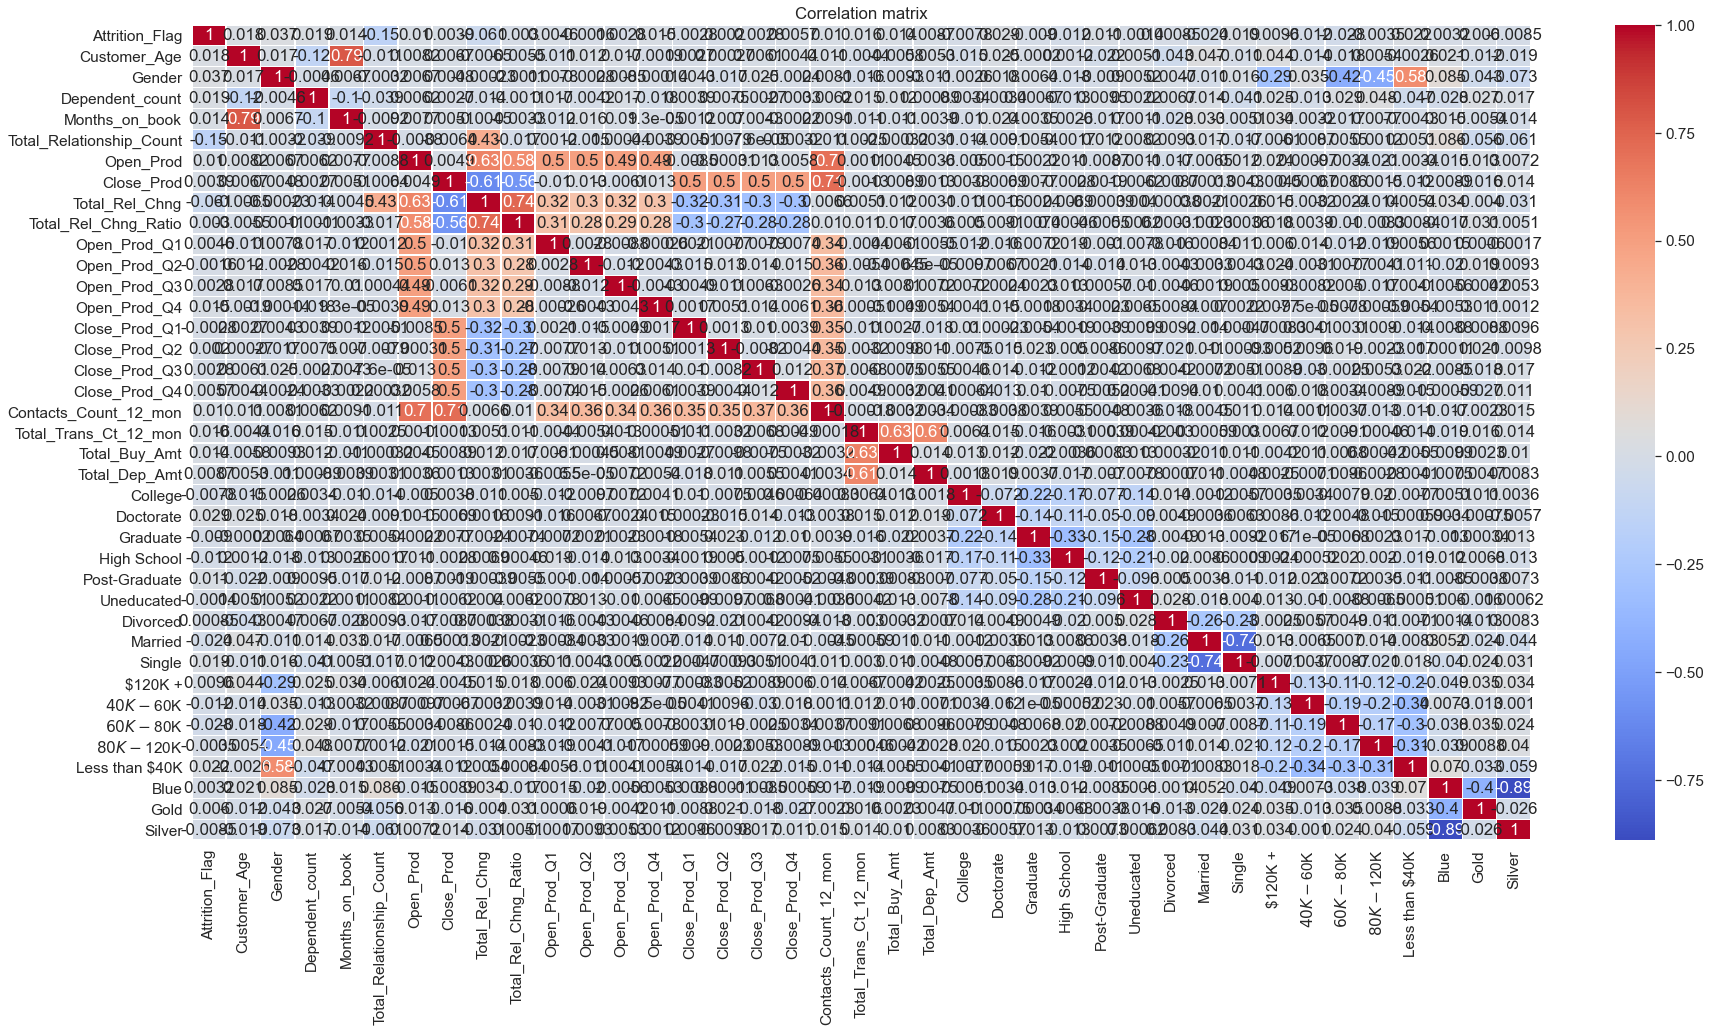

In [8]:
plt.figure(figsize = (30, 15))

sns.set(font_scale=1.4)
sns.heatmap(c_data.corr(), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Из матрицы видно, что есть несколько признаков с повышенной кореляцией, но пока оставим их

Посмотрим на разброс количества действующих клиентов и ушедших

In [9]:
Counter(c_data['Attrition_Flag'])

Counter({0: 8500, 1: 1627})

Необходимо использовать балансировку классов

## Построение модели

Разобьем датасет на тренировочный и тестовый, произведем балансировку классов

In [10]:
X = c_data.drop(['Attrition_Flag'], axis=1)
y = c_data['Attrition_Flag']

# Нормализация данных
mms = MinMaxScaler()
X_mm = mms.fit_transform(X)

In [11]:
# Разобьем датасет на тренировоный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=42)

In [12]:
# Балансировка классов
X_train_balanced, y_train_balanced = SMOTE(sampling_strategy=0.3, random_state=42, n_jobs=-1).fit_resample(X_train, y_train)

In [13]:
# Просмотр результатов
print('До:', Counter(y_train))
print('После:', Counter(y_train_balanced))

До: Counter({0: 5949, 1: 1139})
После: Counter({0: 5949, 1: 1784})


Напишем функции для вычисления качества работы модели

In [14]:
# Функция вычисляющая метрики качества модели
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Метрики модели:')
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll))
    print('ROC AUC: {}'.format(roc_auc))
    return precision, recall, f1, ll, roc_auc


# Функция обучения модели и ее предсказания
def lgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = lgb.LGBMClassifier(max_depth=4,
                             n_estimators=550,
                             learning_rate=0.01,
                             n_jobs=-1,
                             subsample=1.,
                             colsample_bytree=0.5,
                             min_child_weight=3,
                             reg_alpha=0.,
                             reg_lambda=0.,
                             seed=42)
    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf


# Функция отрисовки важности признаков
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

Обучение модели

In [15]:
model = lgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Метрики модели:
Precision: 0.0
Recall: 0.0
F1: 0.0
Log Loss: 0.4302534081911457
ROC AUC: 0.6188548688717379


Проведем отбор признаков

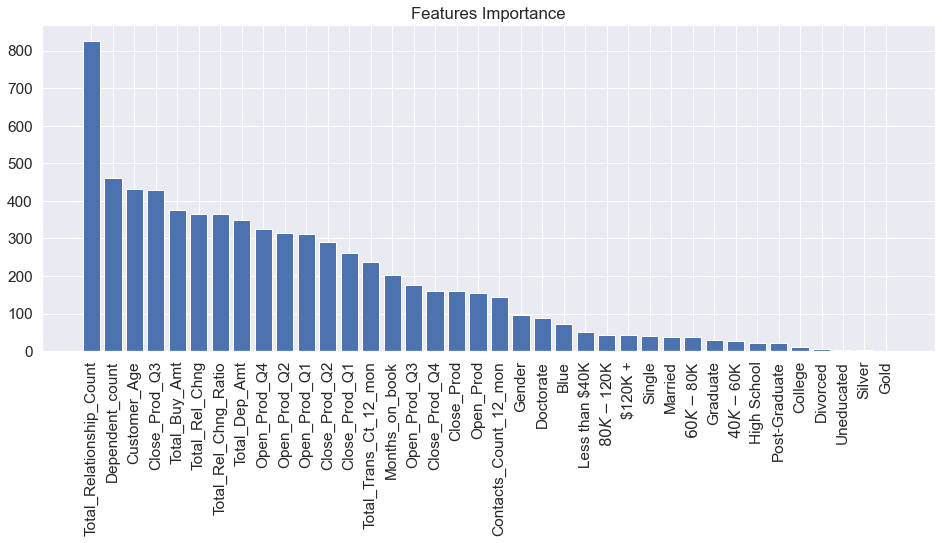

In [16]:
feature_importance = plot_importance(model.feature_importances_, X.columns, 'Features Importance')

In [17]:
# Оставим часть значимых признаков
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:24]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:24]]

model = lgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Метрики модели:
Precision: 0.0
Recall: 0.0
F1: 0.0
Log Loss: 0.4308603114272584
ROC AUC: 0.6154352841380107
Признаков было: 38
Признаков стало: 24


Видим, что признаков стало меньше, а качество практически не изменилось

Построим матрицу ошибок, из которой нам будет видно насколько наша модель корректно определила ушедших клиентов

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

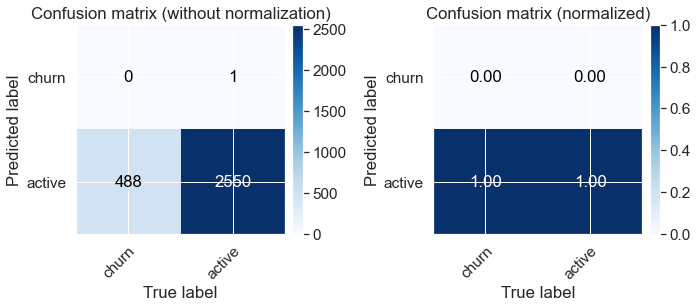

In [19]:
predict_test = model.predict(X_test_FI)

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()